In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import json

import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit
from matplotlib.collections import QuadMesh
from copy import deepcopy as dc

datasets_location = {
    0:'Data/2019-03-20-13-05_07d_01m',
    1:'Data/2019-03-20-13-07_07d_10s',
    2:'Data/2019-03-20-13-08_30d_01m'
}

datasets_full = {
    0:'Data/2019-03-26-11-33_full_30d',
    1:'Data/f_years_full'
}

dataset_json = {
    0:'Data/21-26_datasets'
}

batsim_data={
    '2w':'Data/batsim_2_week/out_jobs',
    '2wm0':'Data/batsim_2_week_modified_0/out_jobs',
    '2wm1':'Data/batsim_2_week_modified_1/out_jobs'
}
plot_size = (12, 8)
sb.set_style('darkgrid')

In [3]:
def fix_date(df):
    df['time'] = df['time'].apply(lambda x:datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ'))

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

def plot(plt, xlabel, ylabel="Count of Entries"):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [4]:
data = []

for i in range(0, 2):
    data.append(pd.read_csv(datasets_full[i] + ".csv"))
    data[i]['time'] = pd.to_datetime(data[i]['transfer_history.creation_date_string'], format='%d/%m/%Y\ %H:%M:%S')
    data[i]['hour'] = data[i]['time'].apply(lambda x: x.hour)
    data[i]['day'] = data[i]['time'].apply(lambda x: x.day)
    data[i]['month'] = data[i]['time'].apply(lambda x: x.month)
    data[i]['speed'] = np.where(data[i]['transfer_history.time_transfer_sec'] > 0, data[i]['transfer_history.actually_transferred_size']/data[i]['transfer_history.time_transfer_sec'], data[i]['transfer_history.time_transfer_sec'])

data[1]["qbox_data_size"] = data[1]['transfer_history.qbox'].map(str)
data[1]["qbox_data_size"] = data[1]['qbox_data_size'].map(str) + "|" + data[1]['transfer_history.transfer_size'].map(str)
data[1]["is_cached"] = data[1]['transfer_history.transfer_size'] == data[1]['transfer_history.cached_data_size']
data[1]['transfer_history.qbox_short'] = data[1]['transfer_history.attached_node'].apply(lambda x: (str(x)[-1] + str(x)[5]) if len(str(x)) > 5 else "")

In [5]:
print("Size of dataset : " + str(data[1].shape))
print("Unique Jobs : " + str(len(data[1]['transfer_history.task'].unique().tolist())))
print("Unique Qboxes : " + str(len(data[1]['transfer_history.qbox'].unique().tolist())))
print("Unique datasets sizes : " + str(len(data[1]['transfer_history.transfer_size'].unique().tolist())))

Size of dataset : (35242, 25)
Unique Jobs : 17844
Unique Qboxes : 20
Unique datasets sizes : 417


#### Check how many of the transfers failed

In [6]:
count_success = 0
count_failed = 0

print(np.unique(data[1]['transfer_history.state']))

for value in data[1]['transfer_history.state']:
    if(value == 'Completed'):
        count_success = count_success + 1
    else:
        count_failed = count_failed + 1

print("Completed transfers : " + str(count_success))
print("Failed transfers : " + str(count_failed))

['Completed' 'Failed']
Completed transfers : 34970
Failed transfers : 272


In [7]:
failed_qboxes = []
failed_time = []
failed_duration = []

for index, row in data[1].iterrows():
    if(row['transfer_history.state'] == "Failed"):
        failed_qboxes.append(row['transfer_history.qbox'])
        failed_time.append(row['time'])

temp = pd.DataFrame({'Failed Qboxes' : failed_qboxes, 'Failed Time' : failed_time})
print(temp)

                        Failed Qboxes         Failed Time
0    QBOX-6000-0000-0000-000000000007 2018-09-15 00:04:10
1    QBOX-6000-0000-0000-000000000007 2018-09-15 00:04:07
2    QBOX-5000-0000-0000-000000000004 2018-10-05 00:05:09
3    QBOX-5000-0000-0000-000000000004 2018-10-06 01:41:09
4    QBOX-e000-0000-0000-000000000004 2018-10-15 19:38:54
5    QBOX-e000-0000-0000-000000000004 2018-10-15 19:41:30
6    QBOX-e000-0000-0000-000000000004 2018-10-16 08:41:35
7    QBOX-e000-0000-0000-000000000004 2018-10-16 08:55:33
8    QBOX-e000-0000-0000-000000000004 2018-10-16 13:53:26
9    QBOX-5000-0000-0000-000000000004 2018-10-18 00:00:18
10   QBOX-5000-0000-0000-000000000004 2018-10-18 00:00:31
11   QBOX-5000-0000-0000-000000000004 2018-10-18 00:00:41
12   QBOX-5000-0000-0000-000000000004 2018-10-18 00:00:57
13   QBOX-5000-0000-0000-000000000004 2018-10-18 00:01:07
14   QBOX-5000-0000-0000-000000000004 2018-10-18 00:01:07
15   QBOX-5000-0000-0000-000000000004 2018-10-18 00:01:07
16   QBOX-5000

The failures are close in time. This says that failures are linked and are at each cluster of time when the failures occur, it was possibly one exact issue. Look at 1-4, 6-14.

#### Up vs Down

In [8]:
count_up = 0
count_down = 0

print(np.unique(data[1]['transfer_history.transfer_direction']))

for value in data[1]['transfer_history.transfer_direction']:
    if(value == "Down"):
        count_down = count_down + 1
    else:
        count_up = count_up + 1

print("Up transfers : " + str(count_up))
print("Down transfers : " + str(count_down))

['Down']
Up transfers : 0
Down transfers : 35242


There are very low up transfers. Thre reason being that most of result the transfers happen via a VPN to the customer's proprietory servers. In such a case, it doesnt reflect in Qarnot systems.

### Validity of transfer and cache sizes

Check if `transfer_history.cached_data_size` + `transfer_history.actually_transferred_size` = `transfer_history.transfer_size`

[27098, 0, 8144]
Entries with difference beyond 100MB : 1738


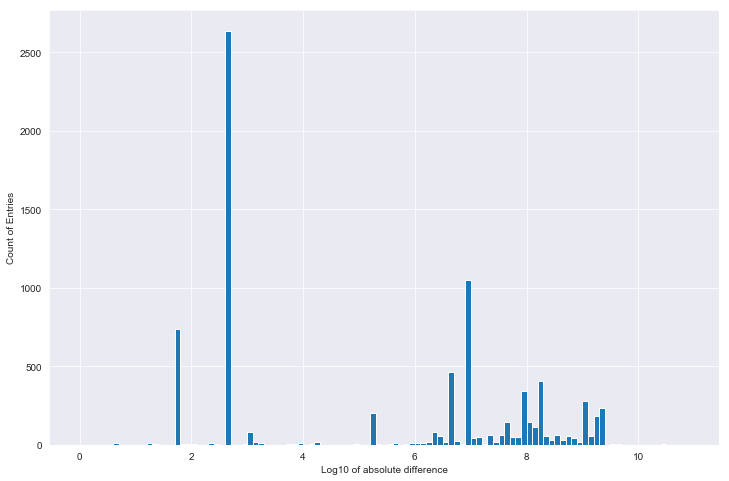

In [9]:
def check_transfer_data(temp, cut):
    count_true = 0
    count_less = 0
    count_more = 0
    more_than_cut = 0
    
    diff_per_list = []
    
    for index, row in temp.iterrows():
        a = row['transfer_history.cached_data_size']
        b = row['transfer_history.actually_transferred_size']
        c = row['transfer_history.transfer_size']
        
        if(a + b == c):
            count_true = count_true + 1
        else:   
            diff_per = abs(c - a - b)
            diff_per_list.append(diff_per)
            
            if(diff_per >= 10**cut):
                more_than_cut = more_than_cut + 1
            
            if(a + b < c):
                count_less = count_less + 1
            else:
                count_more = count_more + 1
    
    return [count_true, count_less, count_more], diff_per_list, more_than_cut

for i in range(1, 2):
    stat, diff, more_than_cut = check_transfer_data(data[i], 8)
    print(stat)
    print("Entries with difference beyond 100MB : " + str(more_than_cut))
    
    plt.figure(figsize=plot_size)
    plt.hist(np.log10(diff), bins=np.arange(0, 11, 0.1))
    plot(plt, "Log10 of absolute difference")

This doesnt match. The difference is mostly around 10 MB, and the transfer_size is always less than the sum. It is an issue with the way this is calculated. Qarnot is aware of this, but is not aware of the very large differences in size (eg. more than 100MB).

### Basic Transfer Size, Transfer Time analysis

The idea behind this analysis is to see if it is possible to extract some useful information regarding the size or the transfers. A good fit to the distrubution will help in speculation.

In [10]:
data_mts = []

for i in range(0, 2):
    data_mts.append(np.array(data[i]["transfer_history.transfer_size"]))
    # print("data[" + str(i) + "]")
    
    # print("Before removing negative and zeros : " + str(len(data_mts[i])))
    
    data_mts[i] = data_mts[i][data_mts[i] > 0.0]
    # print("After removing negative and zeros : " + str(len(data_mts[i])))

In [11]:
data_mtts = []

for i in range(0, 2):
    data_mtts.append(np.array(data[i]["transfer_history.time_transfer_sec"]))
    # print("data[" + str(i) + "]")
    
    # print("After removing negative and zeros : " + str(len(data_mtts[i])))
    
    data_mtts[i] = data_mtts[i][data_mtts[i] > 0.0]
    # print("After removing negative and zeros : " + str(len(data_mtts[i])))

In [12]:
def plot_hist(cut, temp, bins, name, plot_normal = True, plot_log=True, plot_sigma=True,
             plot_cutline=False):
    if(plot_normal):
    # Plot the base histogram
        plt.figure(figsize=plot_size)
        plt.hist(temp, bins=np.arange(bins[0][0], bins[0][1], bins[0][2]))

        # Add the cutline
        if(plot_cutline):
            plt.axvline((10.0 ** cut), color='k', linestyle='dashed')
            # Print stats related to the dotted line
            print("Points above the dotted line : " + str(sum(temp > (10.0 ** cut))))
            print("Total points in the dataset : " + str(len(temp)))
        
        if(False):
            # Add the 99.9 percentile (3 sigma) deviation
            plt.axvline(np.percentile(temp, 50), linestyle='dashed')
            plt.axvline(np.percentile(temp, 10), color='c', linestyle='dashed')
            plt.axvline(np.percentile(temp, 90), color='c', linestyle='dashed')

        # Plot
        plot(plt, name)
    

    if(plot_log):
        # Get the log of the data
        temp = np.log10(temp)

        plt.figure(figsize=plot_size)

        # Now plot the logarithmic historgrams
        plt.hist(temp, bins=np.arange(bins[1][0], bins[1][1], bins[1][2]))


        if(False):
            # Add the 99.9 percentile (3 sigma) deviation
            plt.axvline(np.percentile(temp, 50), linestyle='dashed')
            plt.axvline(np.percentile(temp, 10), color='c', linestyle='dashed')
            plt.axvline(np.percentile(temp, 90), color='c', linestyle='dashed')
        
        plot(plt, "Log of " + name)

### Transfer size

In [13]:
print(sum(np.unique(data_mts[1])))
print(np.mean(data_mts[1]))

125534087076
220255483.98126954


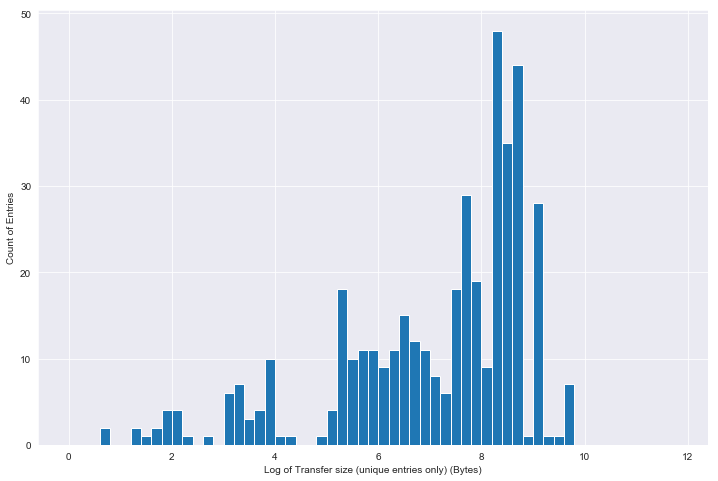

In [14]:
plot_hist(8, np.unique(data_mts[1]), [[0, 10**10, 10**8], [0, 12, 0.2]], "Transfer size (unique entries only) (Bytes)", plot_normal=False)

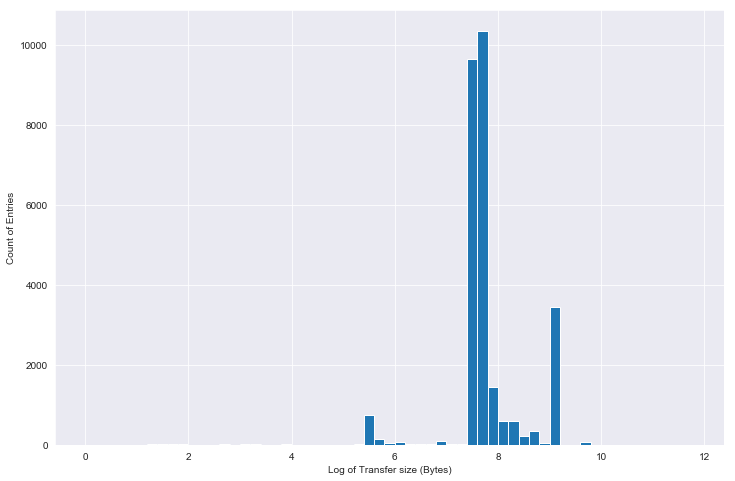

In [15]:
plot_hist(8, data_mts[1], [[0, 10**10, 10**8], [0, 12, 0.2]], "Transfer size (Bytes)", plot_normal=False)

The data given by this CSV file is only for 7, 30 days. We can use the Qarnot data extractor to extract datasets from all the time. This is given as a json output file and we study that here.

In [16]:
data_json_id = []
data_json_size = []

# Open the dataset file
with open(dataset_json[0] + ".json", 'r') as file:

    # Iterate over every line (which is a json object)
    for cnt, line in enumerate(file):

        # Parse this object
        parsed = json.loads(line)

        data_json_id.append(parsed["id"])
        data_json_size.append(parsed["size"])
        
data_json_id = np.array(data_json_id)
data_json_size = np.array(data_json_size)

In [17]:
print("Length of data : " + str(len(data_json_id)))
print("Unique ids in data : " + str(len(np.unique(data_json_id))))
print("Unique datasets in data : " + str(len(np.unique(data_json_size))))

Length of data : 33258
Unique ids in data : 33258
Unique datasets in data : 892


The json file has <job_id, task type, size>. Which always is unique. The code might be processing inside to remove the redundant ones. It is completely possible that jobs failed and so they were restarted with the same id, task type and obviously the same dataset.

Also the probability that the size is same is very small.

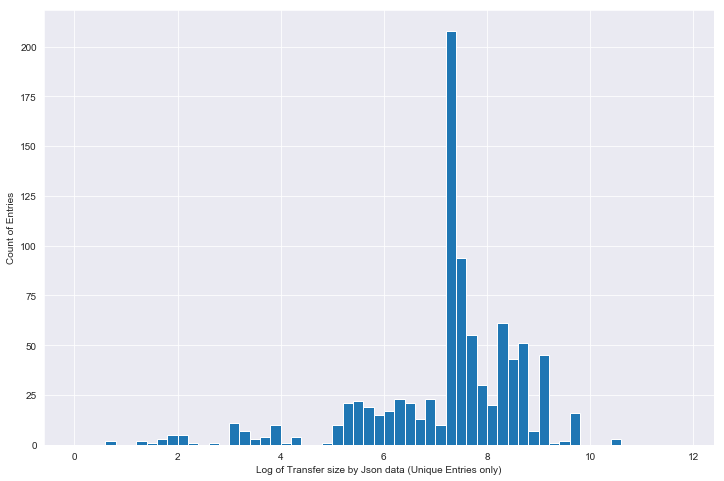

In [18]:
plot_hist(8, np.unique(data_json_size[data_json_size > 0]), [[0, 10**10, 10**8], [0, 12, 0.2]], "Transfer size by Json data (Unique Entries only)", plot_normal=False)

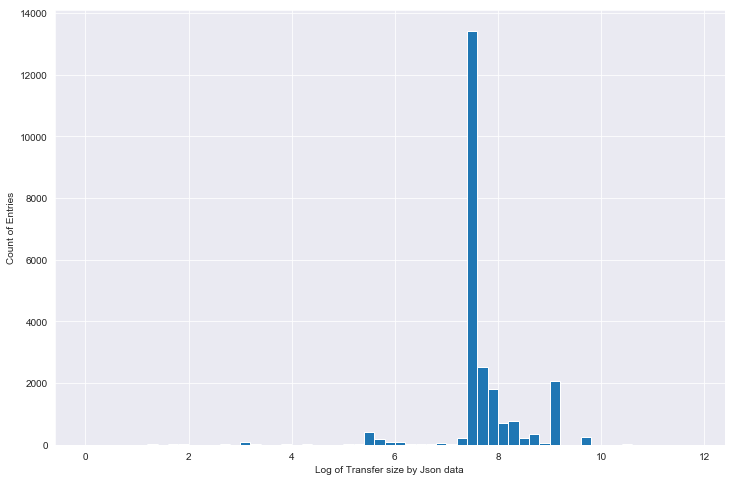

In [19]:
plot_hist(8, data_json_size[data_json_size > 0], [[0, 10**11, 10**9], [0, 12, 0.2]], "Transfer size by Json data", plot_normal=False)

The distribution of this looks the same as from the CSV file, but still this doesnt feel like it is fitting in some distribution. But it is good to have consitency.

### Transfer Time

Time transfer times from influxDB for 2 weeks

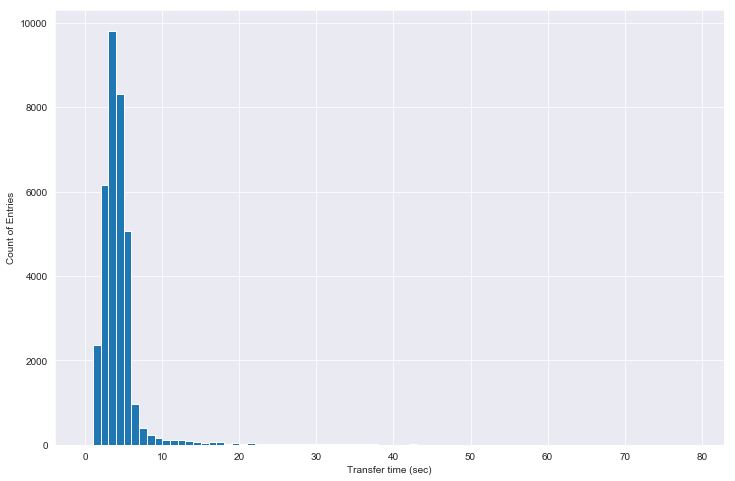

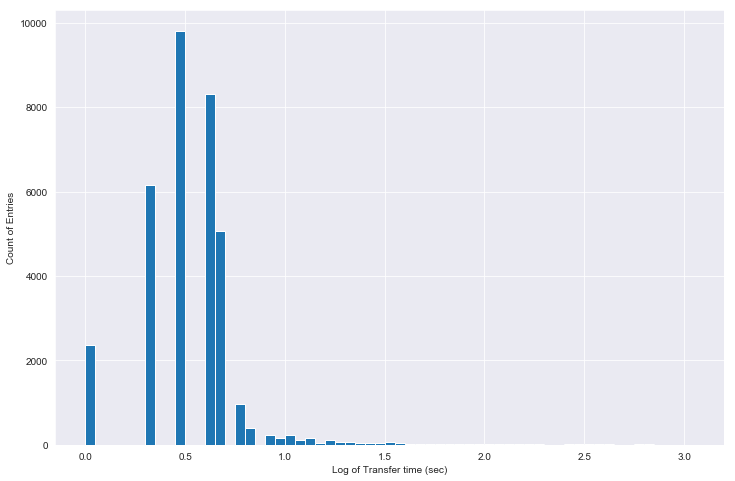

In [20]:
plot_hist(np.log10(20), data_mtts[1], [[0, 8*(10**1), 1*(10**0)], [0, 3.1, 0.05]], "Transfer time (sec)")

Transfer time from batsim jobs output for 2 weeks

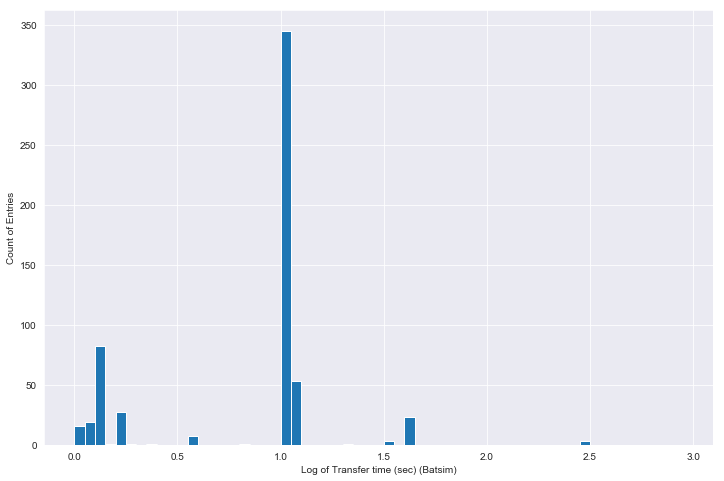

In [21]:
data_batsim = pd.read_csv(batsim_data['2wm1'] + ".csv")
timings = data_batsim[data_batsim['profile'].str.contains('staging')]['execution_time']

plot_hist(np.log10(20), timings, [[0, 200, 5], [0, 3, 0.05]], "Transfer time (sec) (Batsim)", plot_normal=False)

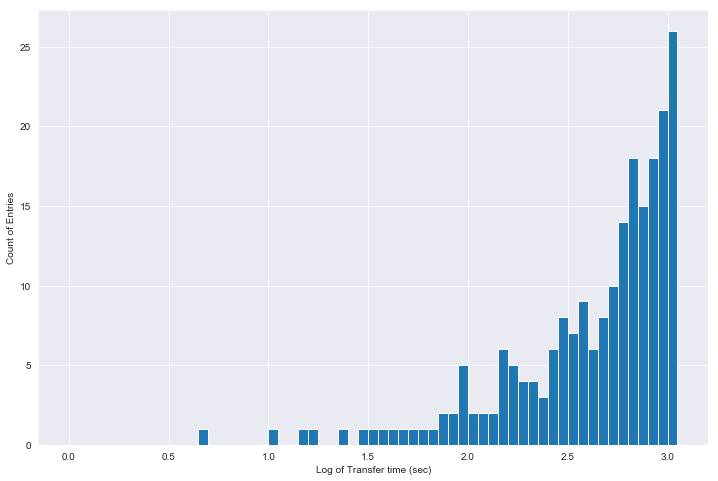

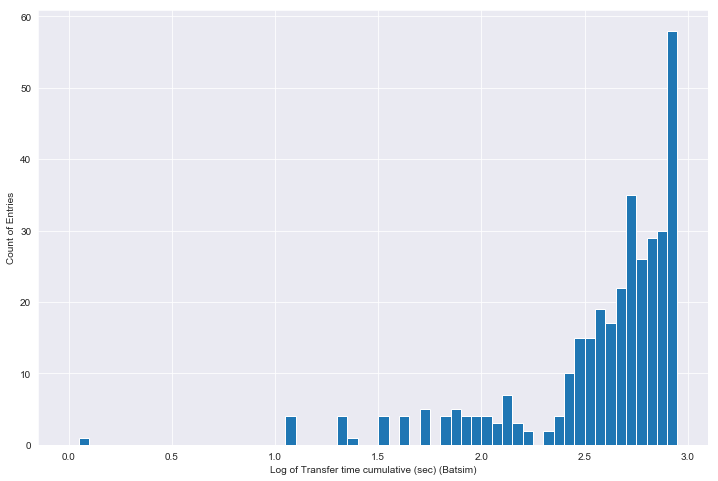

In [22]:
timings_cumu = np.cumsum(timings)
data_mtts_cumu = np.cumsum(data_mtts[0])

plot_hist(np.log10(20), data_mtts_cumu, [[0, 8*(10**1), 1*(10**0)], [0, 3.1, 0.05]], "Transfer time (sec)", plot_normal=False)
plot_hist(np.log10(20), timings_cumu, [[0, 200, 5], [0, 3, 0.05]], "Transfer time cumulative (sec) (Batsim)", plot_normal=False)

### Transfer Speed analysis

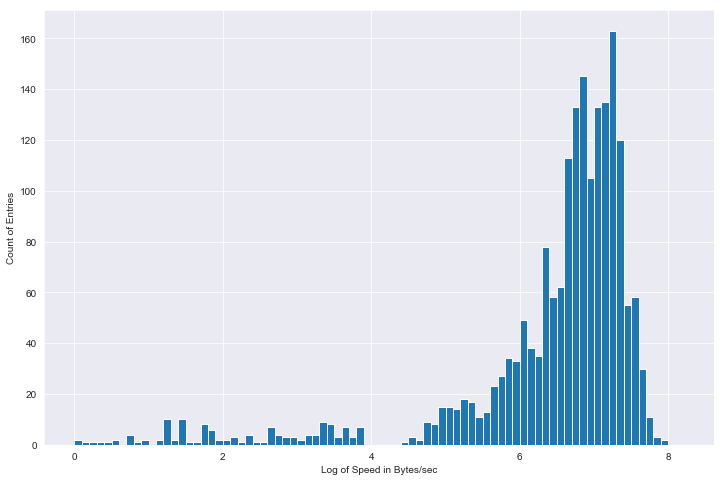

In [23]:
temp = data[1][['speed', 'transfer_history.time_transfer_sec', 'transfer_history.actually_transferred_size']]
temp = temp[temp['transfer_history.time_transfer_sec'] > 0]
temp = temp[temp['transfer_history.actually_transferred_size'] > 0]
temp = temp[temp['speed'] > 0]

plot_hist(np.log10(125000000), temp['speed'], [[0, 1*(10**8), 4*(10**6)], [0, 8.3, 0.1]], "Speed in Bytes/sec", plot_normal=False)

### Analysis of how the jobs map to data

In [24]:
print("Length of data : " + str(len(data[1]["transfer_history.task"])))
print("Unique jobs in data : " + str(len(data[1]["transfer_history.task"].unique().tolist())))

temp = set()
for index, row in data[1].iterrows():
    temp_ = row["transfer_history.task"]
    temp_ = str(temp_ ) + str(row["transfer_history.transfer_type"])
    temp.add(temp_)

print("Unique entries after adding task with type : " + str(len(temp)))

unique_data = len(data[1]["transfer_history.transfer_size"].unique().tolist())
print("Unique entries assuming that every dataset is of different size : " + str(unique_data))

Length of data : 35242
Unique jobs in data : 17844
Unique entries after adding task with type : 20718
Unique entries assuming that every dataset is of different size : 417


Surprising! There are very less unique datasets in the 30 month trace. 

On an average, a job is run 4 times, with possibly unique datases. Datasets are used on an average of 60 times with possibly different jobs.

% jobs which use more than one dataset : 53.9568345323741
% datasets which are used by more than one job : 16.11746245236494


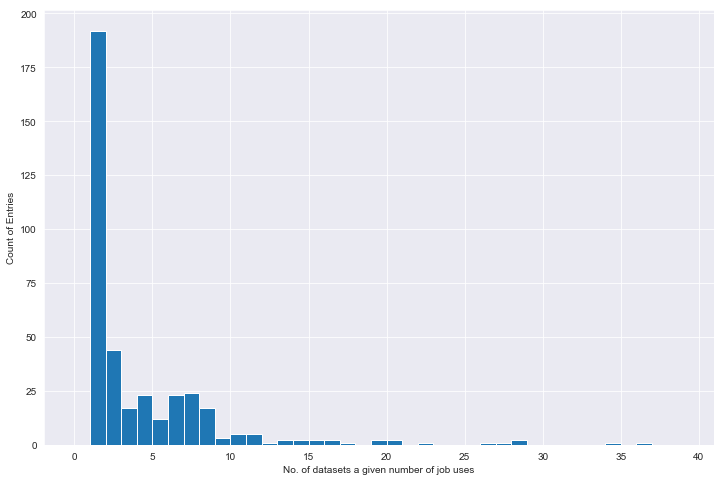

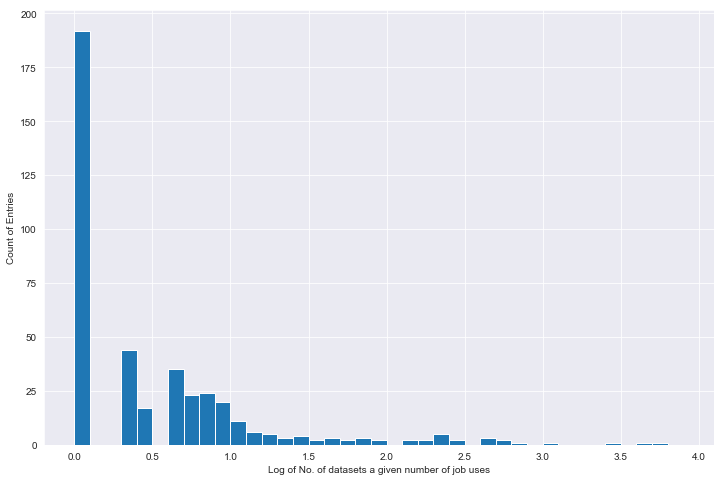

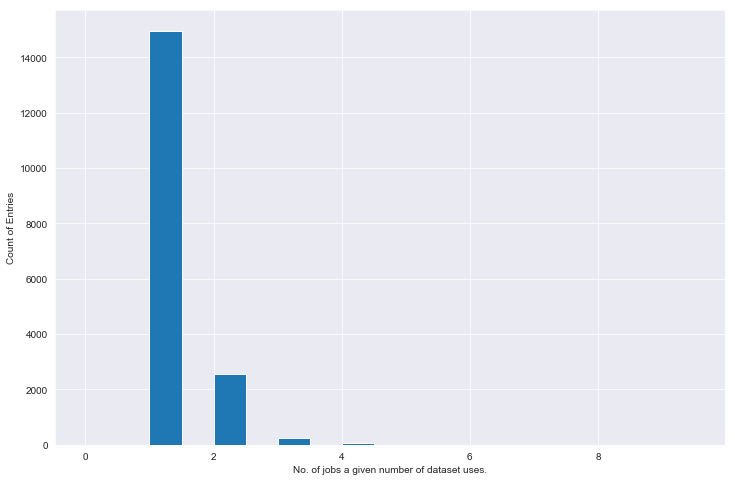

In [25]:
temp = data[1].groupby(['transfer_history.transfer_size', 'transfer_history.task'])
temp = temp.size().unstack()

temp_bool = temp.notna()

temp_bool_data_to_job = np.array(temp_bool.sum(axis=1))
temp_bool_data_to_job_ = temp_bool_data_to_job[temp_bool_data_to_job > 1]
percent = 100*float(len(temp_bool_data_to_job_))/len(temp_bool_data_to_job)
print("% jobs which use more than one dataset : " + str(percent))

temp_bool_job_to_data = np.array(temp_bool.sum(axis=0))
temp_bool_job_to_data_ = temp_bool_job_to_data[temp_bool_job_to_data > 1]
percent = 100*float(len(temp_bool_job_to_data_))/len(temp_bool_job_to_data)
print("% datasets which are used by more than one job : " + str(percent))

plot_hist(np.log10(300), temp_bool_data_to_job, [[0, 40, 1], [0, 4, 0.1]], "No. of datasets a given number of job uses", plot_normal=True)
plot_hist(np.log10(5), temp_bool_job_to_data, [[0, 10, 0.5], [0, 1, 0.1]], "No. of jobs a given number of dataset uses.", plot_log=False)

The distribution gives us more insight into how the job and the dataset dependency works.

### Cache analysis of datasets

Data is cached in the Qbox if `transfer_history.transfer_size` is equal to `transfer_history.cached_data_size`

In [26]:
complete_entries = 0
partial_entries = 0
new_entries = 0

for index, row in data[1].iterrows():
    if(row['transfer_history.actually_transferred_size'] == 0):
        complete_entries = complete_entries + 1
    elif(row['transfer_history.cached_data_size'] == 0):
        new_entries = new_entries + 1
    else:
        partial_entries = partial_entries + 1

print("Cache completely present in {} entries".format(complete_entries))
print("Cache not present in {} entries".format(new_entries))
print("Cache partially present in {} entries".format(partial_entries))

Cache completely present in 33327 entries
Cache not present in 909 entries
Cache partially present in 1006 entries


In [27]:
print("Data shape initially : " + str(data[1].shape))
temp = dc(data[1][data[1]["transfer_history.state"] == "Completed"])
print("Data shape after dropping failed transfers : " + str(temp.shape))
temp = temp[["qbox_data_size", 'transfer_history.qbox', 'transfer_history.transfer_size', "is_cached"]]

temp = temp.dropna()
print("Data shape after dropping na : " + str(temp.shape))
print()
print("Unique Qboxes : " + str(len(temp['transfer_history.qbox'].unique().tolist())))
print("Unique datasets sizes : " + str(len(temp['transfer_history.transfer_size'].unique().tolist())))

Data shape initially : (35242, 25)
Data shape after dropping failed transfers : (34970, 25)
Data shape after dropping na : (34970, 4)

Unique Qboxes : 20
Unique datasets sizes : 413


The number of qboxes is very small. Also The number of datasets is very small. Let us see how many of these are related.

In [28]:
temp_ = temp.groupby(['qbox_data_size', 'is_cached'])
temp_ = temp_.size().unstack().reset_index()
print(temp_.shape)

(1206, 3)


Out of the 413x20, only 1206 are valid mappings.

In [29]:
# Entries which are already cached or entries which are cached once"
data_qbox_mismatch = 0
normal_entries = 0
cache_not_present = 0

for index, row in temp_.iterrows():
    # size = int(re.search('|(.+?)', row.index)

    if(np.isnan(row[0]) and np.isnan(row[1])):
        data_qbox_mismatch = data_qbox_mismatch + 1
    elif(np.isnan(row[0]) or row[0] == 1):
        if not np.isnan(row[1]):
            normal_entries = normal_entries + row[1]
    else:
        cache_not_present = cache_not_present + row[0] - 1
        if not np.isnan(row[1]):
            normal_entries = normal_entries + row[1]

print("Entries where cache was present or created : " + str(normal_entries))
print("Entries where cahce was not present : " +  str(cache_not_present))
print("Cache utilization percentage : " + str(100*normal_entries/(normal_entries + cache_not_present)))

Entries where cache was present or created : 26156.0
Entries where cahce was not present : 7805.0
Cache utilization percentage : 77.01775566090515


The reason this is very high is that a dataset is possibly used by 60 other jobs. Also, given that the number of Qboxes is very low, it is very possible that all the data is present everywhere. It is also possible that the jobs always run at the point closes to the customer and so the data always is present there.

This is not scalable though. As size of Qboxes increase, it is not affordable to put all the datasets nearly everywhere. Also when the condition that the process needs to run near the cusomter is removed, the job can be executed nearly anywhere and then the data will need to be equivalently omnipresent.

### Hourly Analysis

In [30]:
def lambda_group_by(x, cg, ca, f1, f2):
    '''
    This function subsets the data x by the cg. 
    Then it applies f1 to each group on ca, and then aggregates using f2
    '''
    y = x.groupby(cg)[ca].apply(lambda x: f1(x))
    return f2(y)

def plot_groupby_with_deviation(d, cg1, cg2, ca, xlabel="", ylabel="", title="", 
                                f11=lambda x: np.mean(x), f12=lambda x: np.mean(x),
                               yscaling=""):
    '''
    Plots the graph by doing a groupby on cg1 and having standard deviation on cg2.
    The values are calculated by having aggregation function f1 on the groupby (on ca) and the deviation using f2
    '''
    temp = d.groupby([cg1, cg2])[ca].apply(f11).to_frame()
    temp_mean = temp.groupby([cg1]).apply(f12)
    temp_std = temp.groupby([cg1]).apply(lambda x: np.std(x))
    
    plt.figure(figsize=plot_size)
    plt.errorbar(temp_mean.reset_index()[cg1], 
                 temp_mean.reset_index()[ca], 
                 yerr=temp_std[ca], 
                 fmt='--o', color='red',
                 ecolor='blue', elinewidth=2)
    if(yscaling != ""):
        plt.ylim(yscaling[0], yscaling[1])
    plt.title(title)
    plot(plt, xlabel, ylabel)

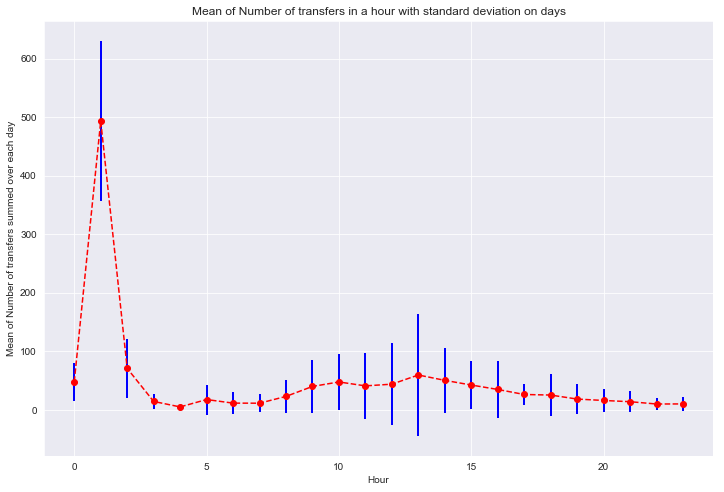

In [31]:
plot_groupby_with_deviation(data[1], 'hour', 'day', 'day',
                            "Hour", "Mean of Number of transfers summed over each day", 
                            "Mean of Number of transfers in a hour with standard deviation on days",
                            f11=lambda x: len(x))

1. At hour 1 a lot of transfers are occurring consistently everyday. The std is also not large.
2. At time around 15, there is a lot of standard deviation.

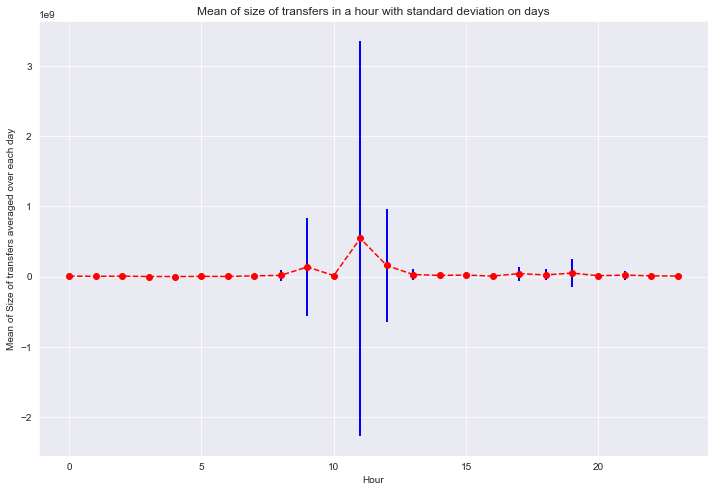

In [32]:
plot_groupby_with_deviation(data[1], 'hour', 'day', 'transfer_history.actually_transferred_size',
                           "Hour", "Mean of Size of transfers averaged over each day", 
                            "Mean of size of transfers in a hour with standard deviation on days")

1. At time 1, the sizes are not bloated out, hence many of the size transfers are going to be either 0 or small.
2. Around 15, this is normal, maybe the cache is well utilized?
3. Datasets at 3, 9, 17 show high variation. Maybe the dataset sizes are very small and very large.


Most of the datasets are in the 10mbs which is consistent with this graph as the y axis is in 1e8. 

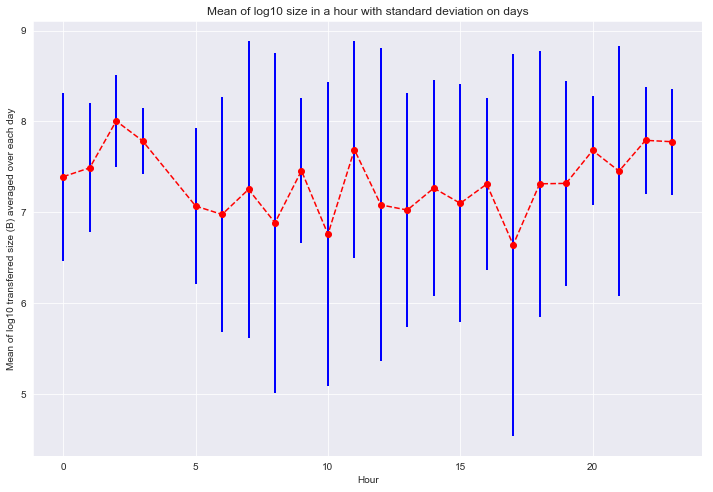

In [33]:
temp = dc(data[1][['hour', 'day', 'transfer_history.actually_transferred_size']])
temp = temp[temp['transfer_history.actually_transferred_size'] > 0]
temp['transfer_history.actually_transferred_size'] = temp['transfer_history.actually_transferred_size'].apply(lambda x:np.log10(x))

plot_groupby_with_deviation(temp, 'hour', 'day', 'transfer_history.actually_transferred_size',
                           "Hour", "Mean of log10 transferred size (B) averaged over each day", 
                            "Mean of log10 size in a hour with standard deviation on days")

1. Taking the log, need to remove the zeroes. Now the points 3, 9, 17 are near the mean and do not show high deviation. Hence a lot of the transfers at this time were of size 0. The std is still relatively large indicating that the sizes of the datasets can be still high.
2. At time 1,2,5 , the transfer sizes are small, I expect the speed to be small too around this time. It would be insteresting to see the cache analysis for this.

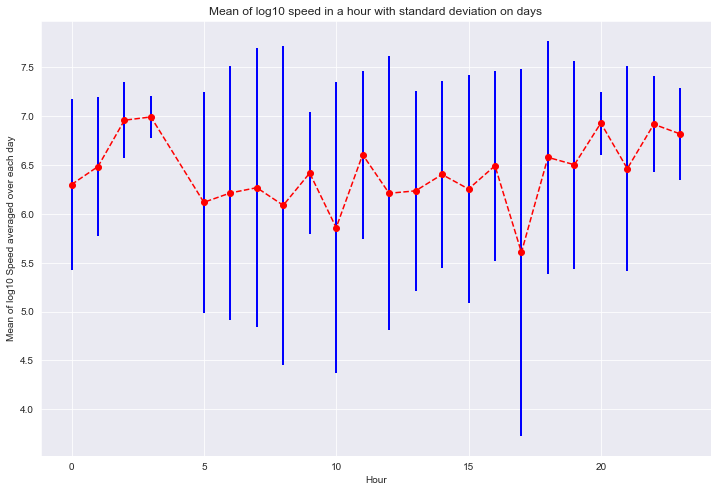

In [34]:
temp = dc(data[1][['hour', 'day', 'speed']])
temp = temp[temp['speed'] > 0]
temp['speed'] = temp['speed'].apply(lambda x:np.log10(x))

plot_groupby_with_deviation(temp, 'hour', 'day', 'speed',
                           "Hour", "Mean of log10 Speed averaged over each day", 
                            "Mean of log10 speed in a hour with standard deviation on days")

1. Here there is very high variation in the speed values. this is mostly because of the small size. Also, the order of this speed is again around 1e8 showing conistency with the size of the dataset and the speed of 1Gbps. So there seems to be no network congestion for now.

So summing up, hour (1,2), 5, (3, 9, 17) were three interesting sets of observations.
1. (1,2) had a lot of transfers but most of them were zero. 
2. 5 had again a lot of zero transfers.
3. 15 had a lot of variation in the count of transfers. But the sizes were again mostly zero.
4. (3, 9, 17) had a lot of zero and large transfers.

The speeds. never throttled and were stable. Hence currently, there seems to be very less of an issue.

### Per Qbox Analysis

1. Qbox 59 equivalent to hour (1, 2).
2. Qbox (12, 45) with very high variation. this is less noticable though.

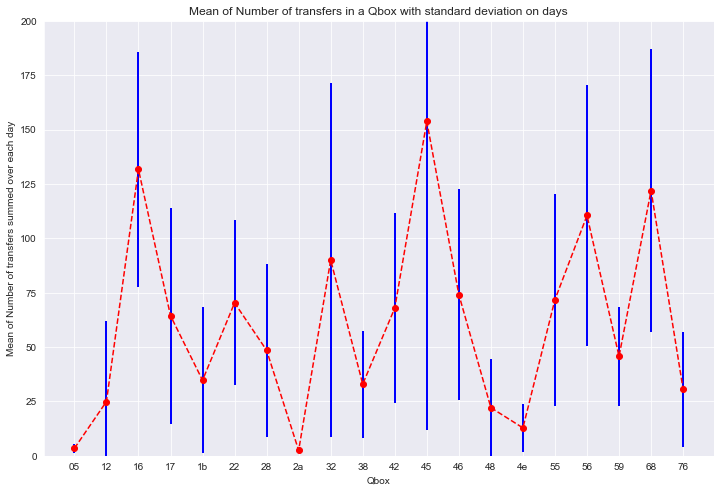

In [35]:
plot_groupby_with_deviation(data[1][data[1]['transfer_history.transfer_direction'] == 'Down'], 
                            'transfer_history.qbox_short', 'day', 'day',
                            "Qbox", "Mean of Number of transfers summed over each day", 
                            "Mean of Number of transfers in a Qbox with standard deviation on days",
                            f11=lambda x: len(x), yscaling=(0, 200))

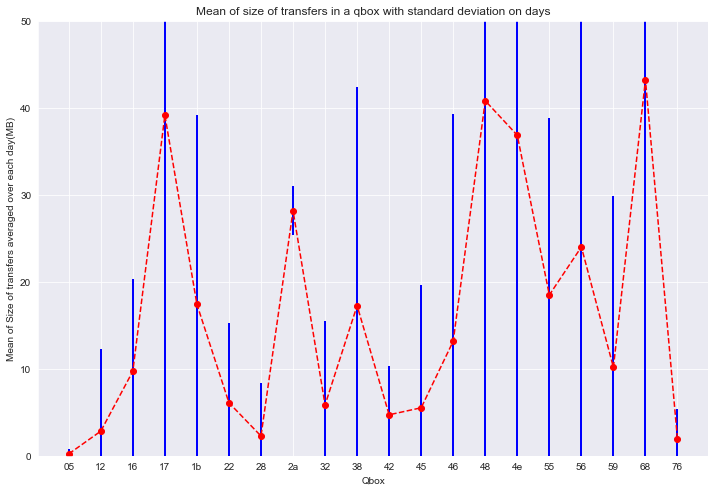

In [36]:
temp = dc(data[1])
temp['transfer_history.actually_transferred_size'] = temp['transfer_history.actually_transferred_size'].apply(lambda x: float(x)/1000000.0)
plot_groupby_with_deviation(temp, 'transfer_history.qbox_short', 'day', 'transfer_history.actually_transferred_size',
                           "Qbox", "Mean of Size of transfers averaged over each day(MB)", 
                            "Mean of size of transfers in a qbox with standard deviation on days",
                           yscaling=(0, 50))

In [37]:
temp = data[1][data[1]['transfer_history.qbox_short'] == '68']
print(temp[['transfer_history.actually_transferred_size', 'day']].groupby('transfer_history.actually_transferred_size').count())

                                             day
transfer_history.actually_transferred_size      
0                                           3580
55                                             1
95                                             1
110                                            1
1596                                           1
1729                                           1
6415                                           1
8280                                           1
12960                                          1
16085                                          1
181922                                         1
456901                                         1
676441                                         1
707828                                         1
936905                                         1
1180844                                        1
1284524                                        1
1287876                                        1
1903372             

1. Very high variation around (2a, 55).
2. Qbox 12, 45 seem nomal. Hence maybe the cache at them was utilized well.

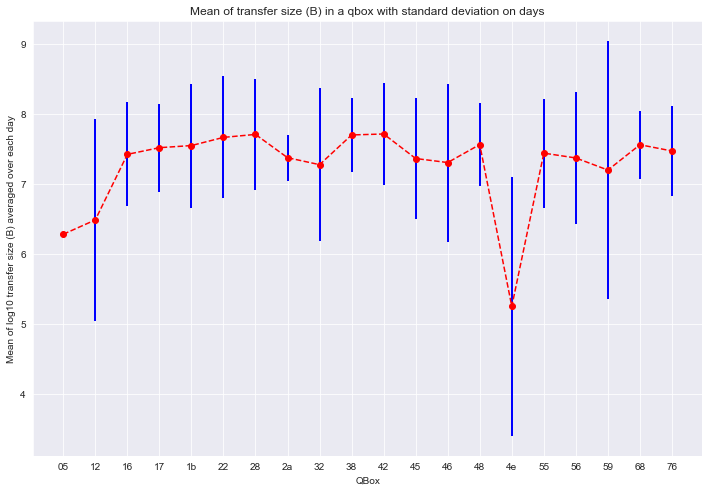

In [38]:
temp = dc(data[1][['transfer_history.qbox_short', 'day', 'transfer_history.actually_transferred_size']])
temp = temp[temp['transfer_history.actually_transferred_size'] > 0]
temp['transfer_history.actually_transferred_size'] = temp['transfer_history.actually_transferred_size'].apply(lambda x:np.log10(x))

plot_groupby_with_deviation(temp, 'transfer_history.qbox_short', 'day', 'transfer_history.actually_transferred_size', 
                           "QBox", "Mean of log10 transfer size (B) averaged over each day", 
                            "Mean of transfer size (B) in a qbox with standard deviation on days")

1. Point (2a, 55) after removing 0 shows low deviation. This is similar to hour (3, 9, 17).
2. Point 59, again is similar to hour (1, 2).
3. Point (42, 44) show small transfer size too. This is equivalent to hour 5.

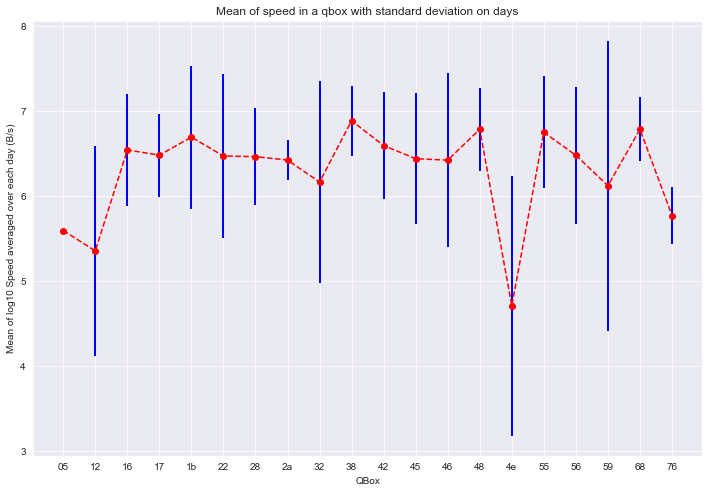

In [39]:
temp = dc(data[1][['transfer_history.qbox_short', 'day', 'speed']])
temp = temp[temp['speed'] > 0]
temp['speed'] = temp['speed'].apply(lambda x:np.log10(x))

plot_groupby_with_deviation(temp, 'transfer_history.qbox_short', 'day', 'speed', 
                           "QBox", "Mean of log10 Speed averaged over each day (B/s)", 
                            "Mean of speed in a qbox with standard deviation on days")

(2a, 55) == (3, 9, 17)
1. Large deviation in the transfer sizes.
2. Very high deviation in size which reduces when taken log
3. A lot of zero and large transfers

(59)     == (1, 2)
1. Very large number of transfers.
2. The mean transfer size reduced when log is taken.
3. Low speed of transfer
4. A lot of zero transfers and small transfers.

(42, 44) == (5)
1. Drop in transfer size when zeros were removed.
2. Very slow speed of transfer.
3. A lot of zero and small transfers.

(12, 45) == (15)
1. A lot of deviation in the transfers.
2. Low data size as this is not reflected in the size analysis. Most of the entries have to be zero.

### Per Hour Per Qbox analysis 

In [40]:
def plot_heatmap(d, cx, cy, ca, cc, f_group, f_column, ylabel="", xlabel="", title=""):
    '''
    Plots a heatmap with cx, cy as group by, ca as aggregate
    Uses f_group to group after groupby
    Uses f_column to create the column plot below
    '''
    temp = d.groupby([cx, cy])[ca]
    temp = temp.apply(f_group)
    temp = temp.to_frame().reset_index()
    temp = temp.pivot(index=cx, columns=cy, values=ca)


    plt.figure(figsize=plot_size)

    ax1 = plt.subplot2grid((20,20), (0,0), colspan=20, rowspan=18)
    ax2 = plt.subplot2grid((20,20), (19,0), colspan=16, rowspan=1)

    sb.heatmap(temp, ax=ax1, linecolor='b', center=0.4, xticklabels=False)
    ax1.set_xlabel("")

    temp = d.groupby(cy)[cc].apply(f_column).to_frame().transpose()

    sb.heatmap(temp, annot=True, ax=ax2, cbar=False, yticklabels=False, cmap="YlGnBu", fmt='g')

    ax1.set_ylabel(ylabel)
    ax2.set_xlabel(xlabel)
    ax1.set_title(title)
    plt.show()

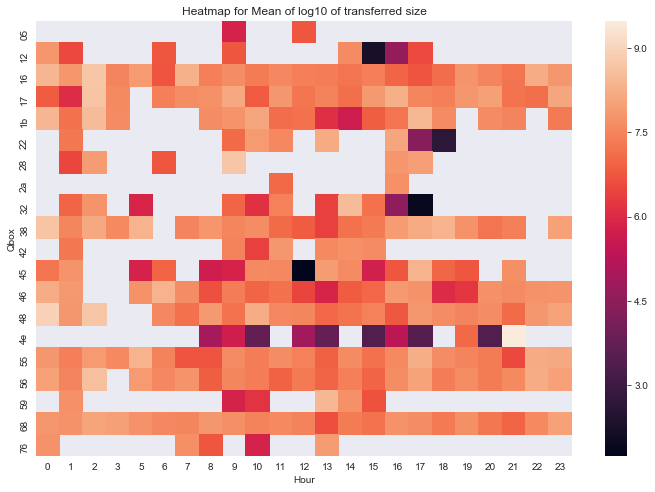

In [41]:
temp = dc(data[1][['transfer_history.qbox_short', 'hour', 'transfer_history.actually_transferred_size']])
temp = temp[temp['transfer_history.qbox_short'].notna()]
temp = temp[temp['transfer_history.actually_transferred_size'] > 0]
temp['transfer_history.actually_transferred_size'] = temp['transfer_history.actually_transferred_size'].apply(lambda x: np.log10(x))
temp = temp.groupby(['transfer_history.qbox_short', 'hour'])['transfer_history.actually_transferred_size'].mean()
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox_short', columns='hour', values='transfer_history.actually_transferred_size')

plt.figure(figsize=plot_size)
sb.heatmap(temp)
plt.xlabel("Hour")
plt.ylabel("Qbox")
plt.title("Heatmap for Mean of log10 of transferred size")
plt.show()

(2a, 55) x (3, 9, 17) : Blank
        (59) x (1, 2) : Black (Small Transfers)
       (42, 44) x (5) : Blank

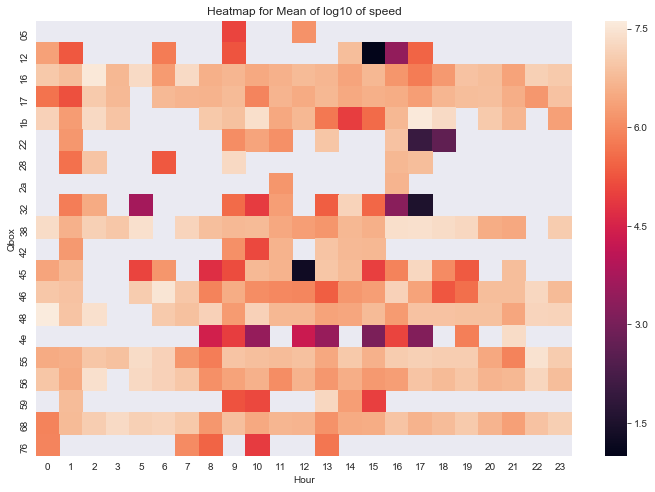

In [42]:
temp = dc(data[1][['transfer_history.qbox_short', 'hour', 'speed']])
temp = temp[temp['transfer_history.qbox_short'].notna()]
temp = temp[temp['speed'] > 0]
temp['speed'] = temp['speed'].apply(lambda x: np.log10(x))
temp = temp.groupby(['transfer_history.qbox_short', 'hour'])['speed'].mean()
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox_short', columns='hour', values='speed')

plt.figure(figsize=plot_size)
sb.heatmap(temp)
plt.xlabel("Hour")
plt.ylabel("Qbox")
plt.title("Heatmap for Mean of log10 of speed")
plt.show()

The above plots nearly look the same, suggesting they have a high correlation. Hence it is highly probable that the dataset is small and hence the download speed is also small. This does not show any network congestions. If there were any network congestions, there would be some points in the above heatmap where the transferred size would have been very high and the speed to be very low.

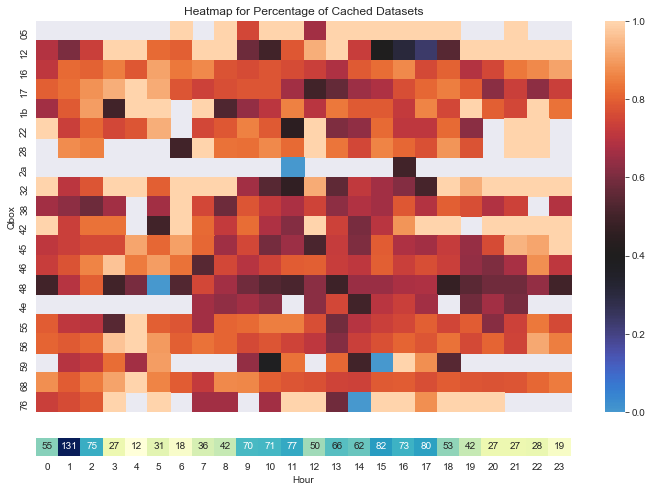

In [43]:
plot_heatmap(data[1], 'transfer_history.qbox_short', 'hour', 'is_cached', 'transfer_history.transfer_size',
             lambda x: float(sum(x == True))/float(sum(x == True) + sum(x == False)), 
             lambda x: len(np.unique(x)), 
             ylabel="Qbox", xlabel="Hour", title="Heatmap for Percentage of Cached Datasets")

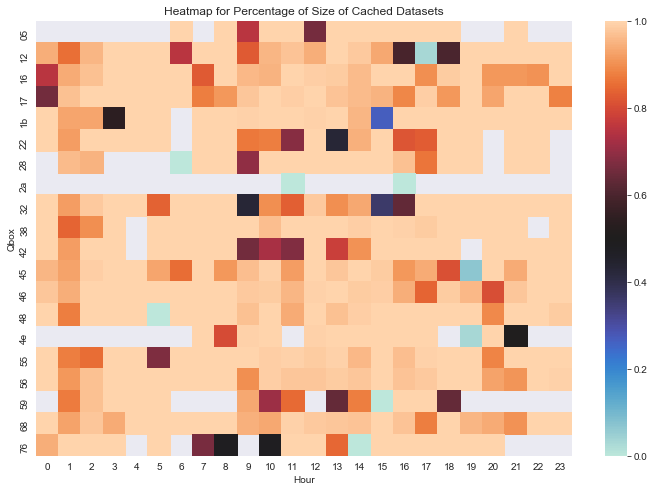

In [44]:
def get_cached_size(x):
    a1 = np.array(x['is_cached'])
    a2 = np.array(x['transfer_history.transfer_size'])
    if(sum(a2) == 0):
        return 0
    num = float(sum(np.multiply(a1, a2)))
    denom = sum(a2)
    return num/denom

temp = dc(data[1][['transfer_history.qbox_short', 'hour', 'is_cached', 'transfer_history.transfer_size']])
temp = temp[temp['transfer_history.qbox_short'].notna()]
temp = temp.groupby(['transfer_history.qbox_short', 'hour'])[['is_cached', 'transfer_history.transfer_size']]
temp = temp.apply(get_cached_size)
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox_short', columns='hour', values=0)

plt.figure(figsize=plot_size)
sb.heatmap(temp, center=0.5)
plt.xlabel("Hour")
plt.ylabel("Qbox")
plt.title("Heatmap for Percentage of Size of Cached Datasets")
plt.show()

### Per Qbox per Day Analysis

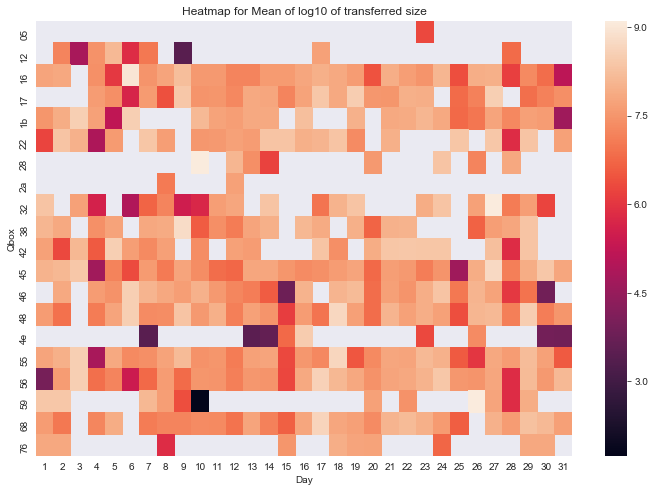

In [45]:
temp = dc(data[1][['transfer_history.qbox_short', 'day', 'transfer_history.actually_transferred_size']])
temp = temp[temp['transfer_history.qbox_short'].notna()]
temp = temp[temp['transfer_history.actually_transferred_size'] > 0]
temp['transfer_history.actually_transferred_size'] = temp['transfer_history.actually_transferred_size'].apply(lambda x: np.log10(x))
temp = temp.groupby(['transfer_history.qbox_short', 'day'])['transfer_history.actually_transferred_size'].mean()
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox_short', columns='day', values='transfer_history.actually_transferred_size')

plt.figure(figsize=plot_size)
sb.heatmap(temp)
plt.xlabel("Day")
plt.ylabel("Qbox")
plt.title("Heatmap for Mean of log10 of transferred size")
plt.show()

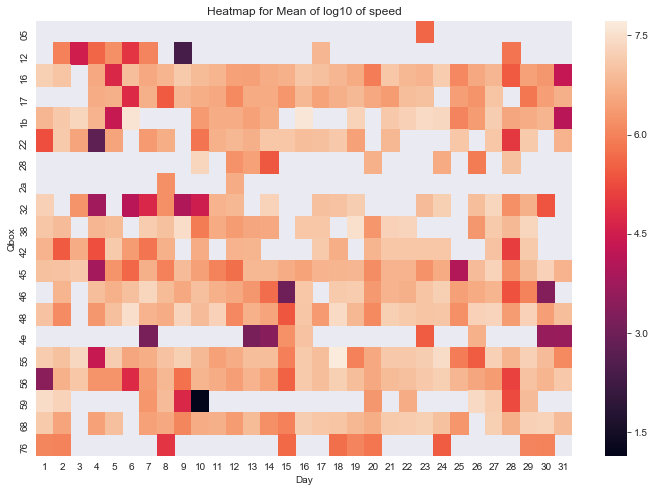

In [46]:
temp = dc(data[1][['transfer_history.qbox_short', 'day', 'speed']])
temp = temp[temp['transfer_history.qbox_short'].notna()]
temp = temp[temp['speed'] > 0]
temp['speed'] = temp['speed'].apply(lambda x: np.log10(x))
temp = temp.groupby(['transfer_history.qbox_short', 'day'])['speed'].mean()
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox_short', columns='day', values='speed')

plt.figure(figsize=plot_size)
sb.heatmap(temp)
plt.xlabel("Day")
plt.ylabel("Qbox")
plt.title("Heatmap for Mean of log10 of speed")
plt.show()

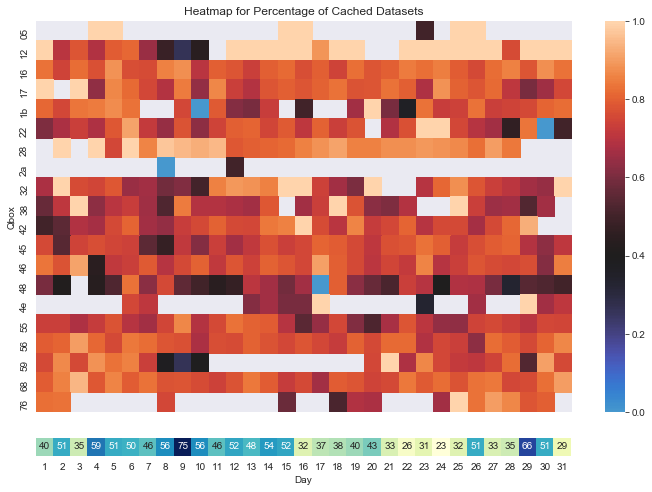

In [47]:
plot_heatmap(data[1], 'transfer_history.qbox_short', 'day', 'is_cached', 'transfer_history.transfer_size',
             lambda x: float(sum(x == True))/float(sum(x == True) + sum(x == False)), 
             lambda x: len(np.unique(x)), 
             ylabel="Qbox", xlabel="Day", title="Heatmap for Percentage of Cached Datasets")

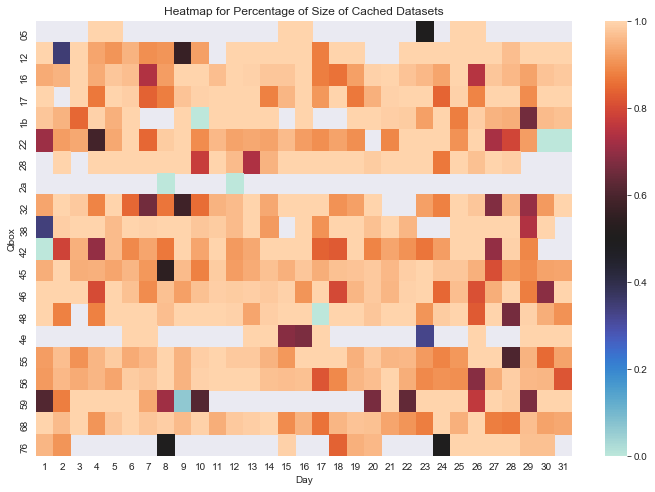

In [48]:
def get_cached_size(x):
    a1 = np.array(x['is_cached'])
    a2 = np.array(x['transfer_history.transfer_size'])
    if(sum(a2) == 0):
        return 0
    num = float(sum(np.multiply(a1, a2)))
    denom = sum(a2)
    return num/denom

temp = data[1][['transfer_history.qbox_short', 'day', 'is_cached', 'transfer_history.transfer_size']]
temp = temp[temp['transfer_history.qbox_short'].notna()]
temp = temp.groupby(['transfer_history.qbox_short', 'day'])[['is_cached', 'transfer_history.transfer_size']]
temp = temp.apply(get_cached_size)
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox_short', columns='day', values=0)

plt.figure(figsize=plot_size)
sb.heatmap(temp, center=0.5)
plt.xlabel("Day")
plt.ylabel("Qbox")
plt.title("Heatmap for Percentage of Size of Cached Datasets")
plt.show()

### Data popularity Analysis

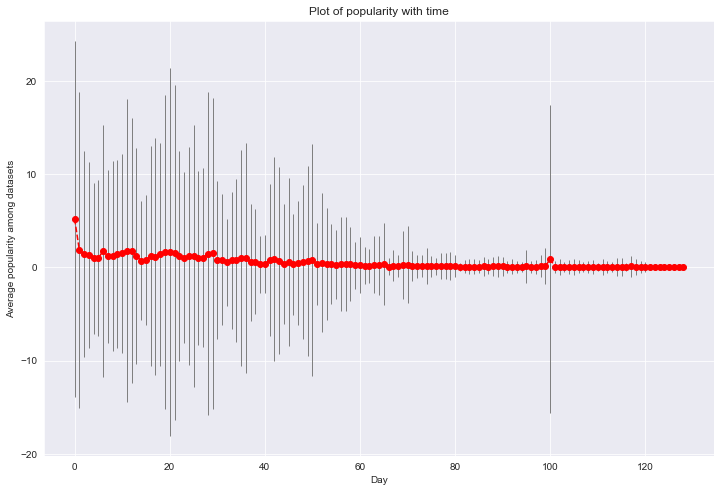

In [49]:
def get_bins(x, l):
    x = np.array(x)
    min_value = np.amin(x)
    y = [(i - min_value).astype('timedelta64[D]')/np.timedelta64(1, 'D') for i in x]
    l.append(y)

def plot_data_popularity(d):
    l = []
    temp = d[['transfer_history.transfer_size', 'time']]
    temp = temp[temp['transfer_history.transfer_size'] > 0.0]
    temp_low = temp.groupby('transfer_history.transfer_size').apply(lambda x: get_bins(x['time'], l))

    for i in range(0, len(l)):
        l[i], bins = np.histogram(l[i], bins=range(0, 130))

    l = np.array(l)
    m = np.mean(l, axis=0)
    n = np.std(l, axis=0)

    plt.figure(figsize=plot_size)
    plt.title("Plot of popularity with time")
    plt.errorbar(np.array(range(0, 129)), m, yerr=n, 
                     fmt='--o', color='red',
                     ecolor='grey', elinewidth=1)
    plt.xlabel("Day")
    plt.ylabel("Average popularity among datasets")
    plt.show()

#for i in range(0, 13):
#    d = data[1][data[1]['month'] == i]
#    if(d.shape[0] != 0):
#        plot_data_popularity(d)

plot_data_popularity(data[1])        

#for i in range(0, len(l)):
#    if(i%40 == 0):
#        plt.figure(figsize=plot_size)
#        #plt.xlim(-1, 15)
#        #plt.ylim(0, 4)
#        a
#    if(len(np.unique(l[i])) < 2):
#        continue
#    
#    sb.distplot(l[i])

### Bandwidth Analysis

In [50]:
temp = data[1][['transfer_history.transfer_size', 'day']]
temp = temp.groupby('day')['transfer_history.transfer_size'].apply(lambda x: len(np.unique(x)))
print("Number of unique datasets requested per day : {}".format(np.mean(temp)))

print("Average size of unique datasets : {}".format(
np.mean(np.unique(data[1]['transfer_history.transfer_size']))))

temp = data[1].groupby('transfer_history.transfer_size')['transfer_history.attached_node'].apply(lambda x: len(np.unique(x)))
print("Average number of qboxes the dataset is present : {}".format(np.mean(temp)))

Number of unique datasets requested per day : 44.225806451612904
Average size of unique datasets : 301040976.20143884
Average number of qboxes the dataset is present : 2.9160671462829737


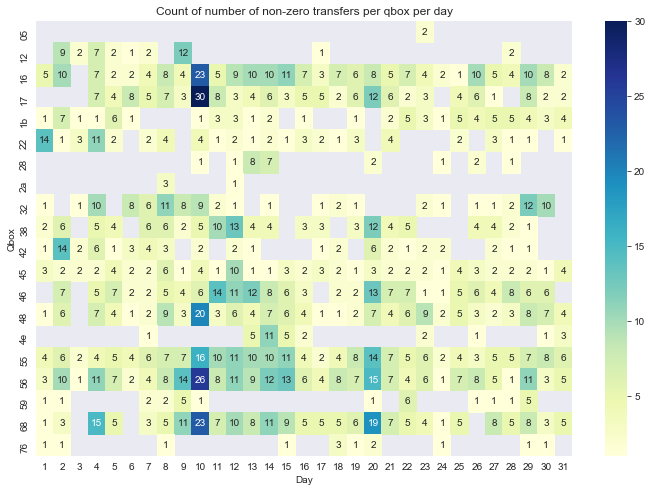

Average number of transfers per qbox per day : 4.835858585858586
Total transfers : 1915


In [51]:
l = []

def accumulate(x):
    l.append(len(x))
    return len(x)

temp = data[1][['transfer_history.qbox_short', 'day', 'transfer_history.actually_transferred_size']]
temp = temp[temp['transfer_history.qbox_short'].notna()]
temp = temp[temp['transfer_history.actually_transferred_size'] > 0]
temp = temp.groupby(['transfer_history.qbox_short', 'day'])['transfer_history.actually_transferred_size'].apply(lambda x: accumulate(x))
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox_short', columns='day', values='transfer_history.actually_transferred_size')

plt.figure(figsize=plot_size)
sb.heatmap(temp, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel("Day")
plt.ylabel("Qbox")
plt.title("Count of number of non-zero transfers per qbox per day")
plt.show()

print("Average number of transfers per qbox per day : {}".format(np.mean(l)))
print("Total transfers : {}".format(sum(l)))

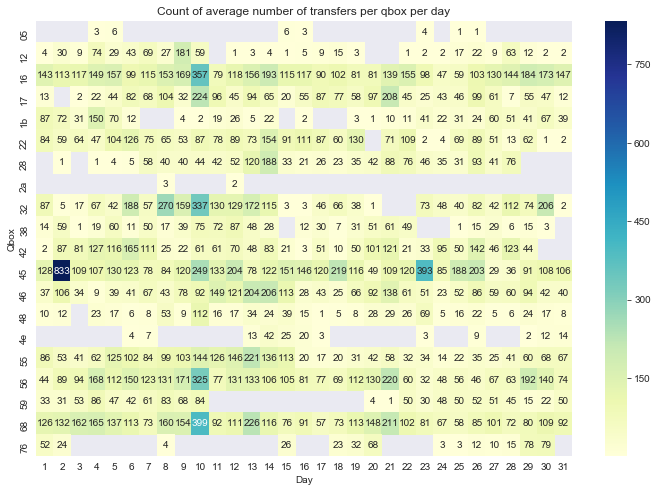

Average number of transfers per qbox per day : 70.76706827309236


In [52]:
l = []

def accumulate(x):
    l.append(len(x))
    return len(x)

temp = data[1][['transfer_history.qbox_short', 'day', 'transfer_history.actually_transferred_size']]
temp = temp.groupby(['transfer_history.qbox_short', 'day'])['transfer_history.actually_transferred_size'].apply(lambda x: accumulate(x))
temp = temp.to_frame().reset_index()

temp = temp.pivot(index='transfer_history.qbox_short', columns='day', values='transfer_history.actually_transferred_size')

plt.figure(figsize=plot_size)
sb.heatmap(temp, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel("Day")
plt.ylabel("Qbox")
plt.title("Count of average number of transfers per qbox per day")
plt.show()

print("Average number of transfers per qbox per day : {}".format(np.mean(l)))